In [26]:
%load_ext autoreload
%autoreload 2
import os
import random

import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataloader import ARMA
from dataloader import ElectricDevices
from hydra.experimental import compose
from hydra.experimental import initialize_config_dir
from interpretability import get_hist
from interpretability import global_interpretability
from interpretability import input_max_neuron
from interpretability import neuron_max_class
from interpretability import shapley_bottleneck_vs_class
from interpretability import shapley_bottleneck_vs_output
from interpretability import shapley_input_vs_bottleneck
from interpretability import shapley_input_vs_class
from interpretability import shapley_input_vs_output
from models.CAE import CAE
from train import Trainer
from utils import accuracy
from utils import data_bottleneck_exploration
from utils import data_input_exploration
from utils import get_predictions
from utils import observation_reconstruction
from utils import reconstruction

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [27]:
with initialize_config_dir(config_dir=os.path.abspath("configs")):
    cfg = compose(config_name="arma")

dl = ElectricDevices()
dl = ARMA(4)
data_train, data_valid, data_test = dl()

X_train, y_train = data_train[:, :, :-1], data_train[:, :, -1]
X_valid, y_valid = data_valid[:, :, :-1], data_valid[:, :, -1]
X_test, y_test = data_test[:, :, :-1], data_test[:, :, -1]

In [28]:
model = CAE(cfg.model, dilation=[2, 3, 5, 7])

improvement: 2

EPOCH 510 train loss: 0.311145062509336, valid loss: 0.35584209467235367
epochs without improvement: 12

EPOCH 520 train loss: 0.3101210547120948, valid loss: 0.3557707369327545
epochs without improvement: 9

EPOCH 530 train loss: 0.3099147034318824, valid loss: 0.36048775283913864
epochs without improvement: 9

EPOCH 540 train loss: 0.3099272455039777, valid loss: 0.3537925230829339
epochs without improvement: 19

EPOCH 550 train loss: 0.30902848431938573, valid loss: 0.3513479703351071
epochs without improvement: 29

EPOCH 560 train loss: 0.30641328817919683, valid loss: 0.3547716736793518
epochs without improvement: 9

EPOCH 570 train loss: 0.3069883804572256, valid loss: 0.35521526085703
epochs without improvement: 19

EPOCH 580 train loss: 0.3045293578976079, valid loss: 0.3539604481897856
epochs without improvement: 29

EPOCH 581 train loss: 0.3049301395290776, valid loss: 0.3477336952560826
epochs without improvement: 30

Training Finished in 498.40477991104126s


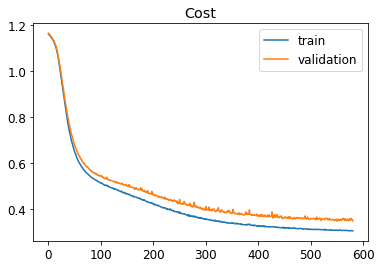

In [44]:
trainer = Trainer(cfg.train)
train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

In [29]:
#torch.save(model.state_dict(), "../weights/arma4.pth")
model.load_state_dict(torch.load("../weights/arma4.pth"))

<All keys matched successfully>

Predict testing data

In [30]:
 X_testp, y_testp = get_predictions(model, X_test)

# Evaluate

## Reconstruction

In [31]:
reconstruction(X_test, X_testp)

Distance Correlation avg and std: 0.8332549738592768 0.05178617648089834
NRMSE: 0.10647989809513092



## Reconstruction of individual observations

In [48]:
SELECTED = [np.random.choice([i for i, x in enumerate(y_test) if int(x) == j]) for j in range(1)]

SELECTED = [3279, 1156, 7419, 5046, 3323, 6485, 5497]

observation_reconstruction(SELECTED, X_test, X_testp, y_test, y_testp)

IndexError: index 3279 is out of bounds for dimension 0 with size 1200

## Accuracy

Accuracy: 0.9708333333333333


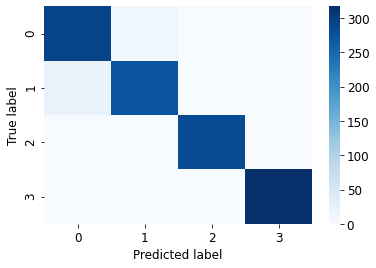

In [51]:
accuracy(y_test, y_testp)

# Data Exploration

In [ ]:
data_input_exploration(X_train)

In [49]:
data_bottleneck_exploration(model, X_train)

KeyboardInterrupt: 

# Interpretability

In [ ]:
global_interpretability(model)

In [ ]:
hist_input = [get_hist(X_train[:, 0, i]) for i in range(cfg.model.length)]
aux = model.encoder(X_train, False).detach().numpy()
hist_bn = [get_hist(aux[:, i]) for i in range(cfg.model.bottleneck_nn)]

In [ ]:
shapley_input_vs_output(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_output(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_bottleneck(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_class(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_class(model, SELECTED, X_test, hist_input)

# Feature Visualization

In [ ]:
input_max_neuron(model)

In [ ]:
neuron_max_class(model)